# MNIST Classification with Classic Features

This notebook demonstrates how to classify the MNIST handwritten digits using classical computer vision features. We extract:

* **Object analysis features** (e.g., area, aspect ratio, eccentricity, solidity, Hu moments) from binarized digits.
* **Texture features** via Local Binary Patterns (LBP).

The combined descriptors feed into a one-vs-all Support Vector Machine (SVM).

The workflow is intentionally simple yet complete:

1. Download the MNIST dataset from OpenML and optionally down-sample it for faster experimentation.
2. Compute geometric and texture descriptors for every digit.
3. Visualize the binary masks and LBP responses to ensure the feature engineering behaves as expected.
4. Train a standardized linear SVM on the feature matrix.
5. Evaluate the classifier with accuracy, a classification report, and a confusion matrix.

Working through these steps highlights how far we can push classic CV techniques before reaching for deep neural networks.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
from skimage.feature import local_binary_pattern
from skimage.measure import label, regionprops, moments_hu

np.random.seed(42)


## Load the MNIST dataset

We load the images and labels from `fetch_openml` and optionally down-sample for quicker experimentation. Images are kept as 28×28 grayscale arrays for feature extraction.


In [2]:
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
images = mnist.data.reshape(-1, 28, 28).astype(np.float32) / 255.0
labels = mnist.target.astype(int)

n_samples = 20000  # adjust down if running on limited hardware
indices = np.random.choice(len(images), size=n_samples, replace=False)
images = images[indices]
labels = labels[indices]

print(f"Dataset subset: {images.shape[0]} samples")


Dataset subset: 20000 samples


### Dataset size heuristics

Fetching all 70k digits is feasible but makes the handcrafted feature extraction slow. The slice controlled by `n_samples` keeps the run lightweight while still covering enough variation. Adjust the number upward when running on a GPU/desktop, or downward on constrained hardware. The images stay as floating-point arrays in `[0, 1]` because the downstream feature functions expect normalized intensities.

## Feature extraction helpers

We treat each 28×28 digit as a grayscale image and derive complementary descriptors:

* **Object analysis**: threshold the image, isolate the largest connected component, and measure region properties. We record normalized area, bounding-box aspect ratio, extent, solidity, eccentricity, and log-scaled Hu moments so that each number captures global shape statistics.
* **Texture**: run a uniform Local Binary Pattern (LBP) detector (radius 2, 16 neighbors) and summarize the counts in a normalized histogram. This captures small-scale stroke variations that the global shape descriptors miss.

Concatenating both vectors yields a compact descriptor that mixes macro and micro characteristics of each digit.

In [3]:
def extract_object_features(image: np.ndarray) -> np.ndarray:
    binary = image > 0.2
    labeled = label(binary)
    props = regionprops(labeled)
    if not props:
        return np.zeros(12, dtype=np.float32)
    region = max(props, key=lambda p: p.area)
    area = region.area / (image.shape[0] * image.shape[1])
    eccentricity = region.eccentricity
    extent = region.extent
    solidity = region.solidity
    minr, minc, maxr, maxc = region.bbox
    height, width = maxr - minr, maxc - minc
    aspect_ratio = width / height if height > 0 else 0.0
    hu = moments_hu(binary.astype(np.float64))
    hu = np.sign(hu) * np.log1p(np.abs(hu))
    return np.hstack([
        area,
        aspect_ratio,
        eccentricity,
        extent,
        solidity,
        hu,
    ]).astype(np.float32)


def extract_texture_features(image: np.ndarray, radius: int = 2, n_points: int | None = None) -> np.ndarray:
    if n_points is None:
        n_points = 8 * radius
    lbp = local_binary_pattern(image, n_points, radius, method="uniform")
    hist, _ = np.histogram(lbp, bins=np.arange(0, n_points + 3), range=(0, n_points + 2), density=True)
    return hist.astype(np.float32)


def extract_features(image: np.ndarray) -> np.ndarray:
    obj_feats = extract_object_features(image)
    tex_feats = extract_texture_features(image)
    return np.hstack([obj_feats, tex_feats])

### Visual sanity check for texture features

Local Binary Patterns are easier to trust when we can see the response maps. Each row below shows one digit: the raw grayscale image, the binary mask used for object features, and the uniform LBP response rendered with a perceptually uniform colormap. If the masks or texture maps look off, it is a cue to revisit the preprocessing parameters.

/home/alirje/ComputerVisionFall404/.venv/lib/python3.13/site-packages/skimage/feature/texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


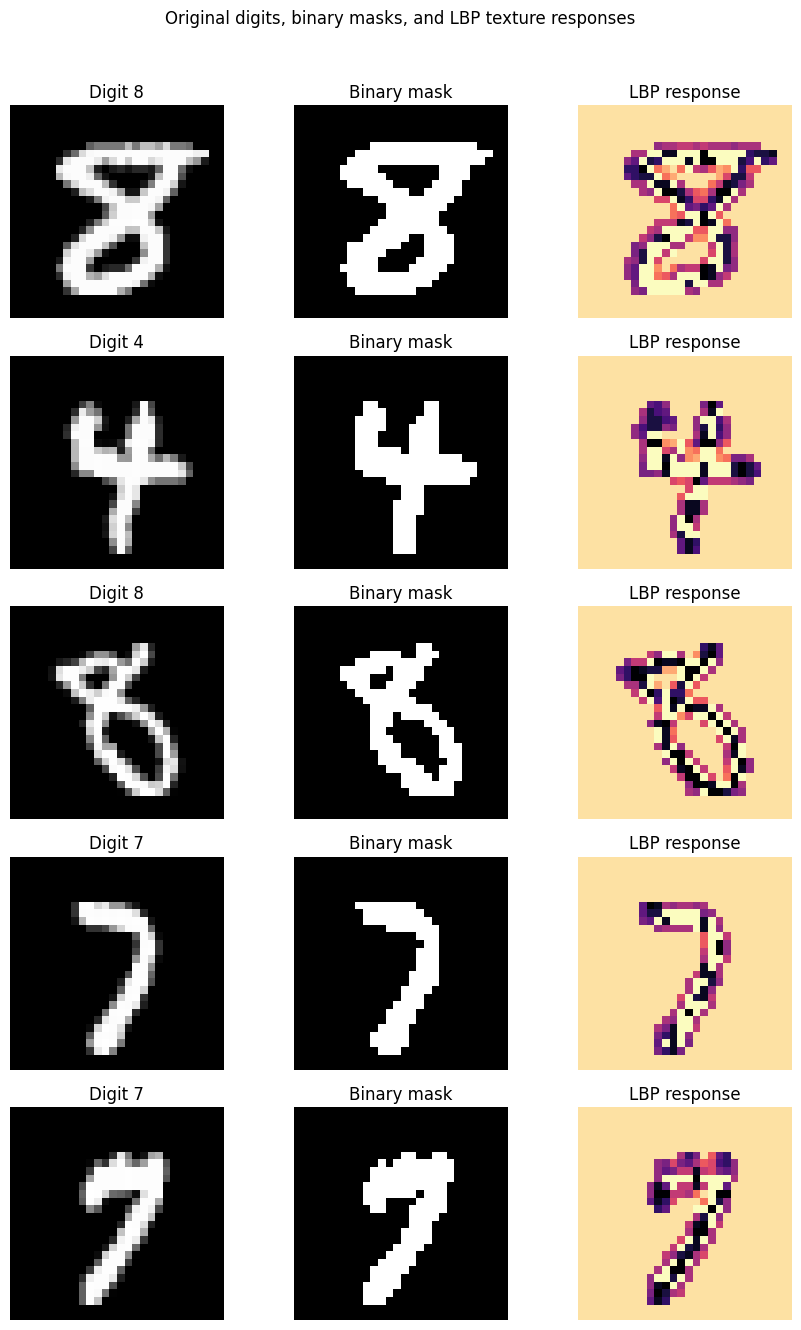

In [4]:
n_examples = 5
fig, axes = plt.subplots(n_examples, 3, figsize=(9, 2.6 * n_examples))
for row, idx in enumerate(range(n_examples)):
    img = images[idx]
    binary = img > 0.2
    lbp = local_binary_pattern(img, 16, 2, method="uniform")

    axes[row, 0].imshow(img, cmap='gray')
    axes[row, 0].set_title(f"Digit {labels[idx]}")
    axes[row, 0].axis('off')

    axes[row, 1].imshow(binary, cmap='gray')
    axes[row, 1].set_title('Binary mask')
    axes[row, 1].axis('off')

    axes[row, 2].imshow(lbp, cmap='magma')
    axes[row, 2].set_title('LBP response')
    axes[row, 2].axis('off')

plt.suptitle('Original digits, binary masks, and LBP texture responses', y=1.02)
plt.tight_layout()
plt.show()

### Notes on the helper functions

* `extract_object_features` thresholds the image at 0.2, keeps the largest component, and returns 12 values (5 geometric descriptors + 7 Hu moments). Taking the log of the Hu moments stabilizes the dynamic range.
* `extract_texture_features` computes uniform LBP codes with 16 points. Binning with `density=True` means the histogram already sums to 1, so each digit contributes equally regardless of stroke width.
* `extract_features` simply concatenates the two vectors so every digit is represented by a 30-dimensional feature vector ready for learning algorithms.

## Build the feature matrix

Apply the helper functions to every image to form the feature matrix `X`. The list comprehension keeps the code compact yet explicit, and `np.vstack` converts the growing list into a contiguous array that downstream scikit-learn estimators expect. We also keep the raw `labels` vector as `y` for reference. Computing the features for 20k digits finishes within a few seconds on a laptop.

In [5]:
feature_list = [extract_features(img) for img in images]
X = np.vstack(feature_list)
y = labels

print(f"Feature matrix shape: {X.shape}")


Feature matrix shape: (20000, 30)


## Train a one-vs-all SVM classifier

Split the dataset into train/test folds using a stratified shuffle so every digit keeps similar class proportions. A `StandardScaler` zero-centers and scales each feature, which is important because Hu moments and histogram bins naturally live on different scales. We then fit a linear `LinearSVC`, which internally solves one binary problem per class (one-vs-all).

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

svm_clf = make_pipeline(
    StandardScaler(),
    LinearSVC(dual=False, random_state=42)
)
svm_clf.fit(X_train, y_train)

y_pred = svm_clf.predict(X_test)

acc = accuracy_score(y_test, y_pred)
print(f"Test accuracy: {acc:.4f}")
print(classification_report(y_test, y_pred))


Test accuracy: 0.6408
              precision    recall  f1-score   support

           0       0.74      0.86      0.80       393
           1       0.94      0.97      0.96       448
           2       0.49      0.23      0.31       408
           3       0.53      0.74      0.62       412
           4       0.61      0.66      0.63       366
           5       0.52      0.33      0.40       365
           6       0.56      0.61      0.58       399
           7       0.59      0.75      0.66       431
           8       0.70      0.87      0.77       382
           9       0.57      0.32      0.41       396

    accuracy                           0.64      4000
   macro avg       0.62      0.63      0.62      4000
weighted avg       0.63      0.64      0.62      4000



### Inspecting the numeric results

`LinearSVC` reports per-class precision/recall/F1 as well as the overall accuracy. If accuracy stalls, consider tweaking:

1. Raising `n_samples` to feed more diverse data into the feature extractor.
2. Tuning `C` (the SVM penalty) or switching to an RBF kernel.
3. Extending the descriptor vector (e.g., multi-scale LBPs or additional region moments).

Tracking these metrics helps ensure tweaks meaningfully improve recognition rather than just reshuffling errors between digits.

## Visualize the confusion matrix

A normalized confusion matrix reveals which digits confuse the classifier. The diagonal shows per-class recall, while off-diagonal entries show systematic confusions (e.g., `4` misread as `9`). Reviewing this plot often exposes whether we need richer descriptors or more balanced training data.

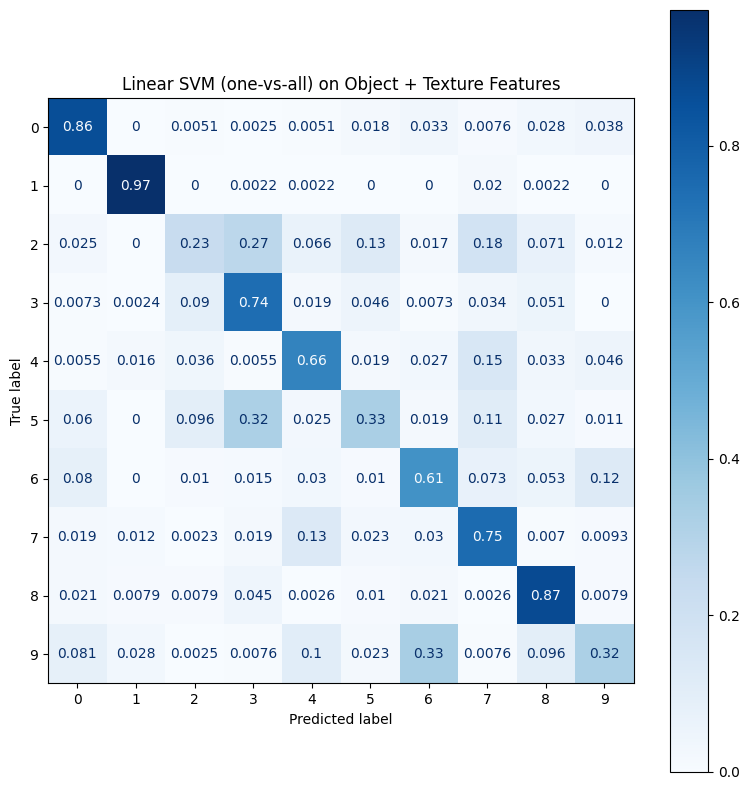

In [7]:
fig, ax = plt.subplots(figsize=(8, 8))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Blues', normalize='true', ax=ax)
ax.set_title("Linear SVM (one-vs-all) on Object + Texture Features")
plt.tight_layout()
plt.show()
